In [1]:
!pip install autogenstudio
import autogen
import datetime
import openai
import os
import pandas as pd
import requests
import yfinance as yf
import sys

from autogen import config_list_from_json
from autogen import AssistantAgent, UserProxyAgent
from dotenv import load_dotenv

ImportError: cannot import name 'config_list_from_json' from 'autogen' (/Users/gongweiying/anaconda3/lib/python3.11/site-packages/autogen/__init__.py)

In [2]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 09-Jun-2024 20:30:01


In [5]:
import openai
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

openai.api_key  = os.getenv('OPENAI_API_KEY')

In [6]:
llm_config = {
    "config_list": [{"model": "gpt-4", "api_key": os.environ["OPENAI_API_KEY"]}],
}

assistant = autogen.AssistantAgent(name="assistant", llm_config=llm_config)

AttributeError: module 'autogen' has no attribute 'AssistantAgent'

In [5]:
import subprocess

def start_autogenstudio_ui(port):
    try:
        # Construct the command to start AutoGenStudio UI on the specified port
        command = ["autogenstudio", "ui", "--port", str(port)]
        
        # Use subprocess to run the command
        process = subprocess.Popen(command)
        
        # Print the process ID for reference
        print(f"AutoGenStudio UI started on port {port} with PID: {process.pid}")
        
    except Exception as e:
        print(f"An error occurred: {e}")

# Start AutoGenStudio UI on port 8081
start_autogenstudio_ui(8081)

AutoGenStudio UI started on port 8081 with PID: 10270


Traceback (most recent call last):
  File "/Users/gongweiying/anaconda3/bin/autogenstudio", line 5, in <module>
    from autogenstudio.cli import run
  File "/Users/gongweiying/anaconda3/lib/python3.11/site-packages/autogenstudio/__init__.py", line 1, in <module>
    from .chatmanager import *
  File "/Users/gongweiying/anaconda3/lib/python3.11/site-packages/autogenstudio/chatmanager.py", line 12, in <module>
    from .workflowmanager import AutoGenWorkFlowManager
  File "/Users/gongweiying/anaconda3/lib/python3.11/site-packages/autogenstudio/workflowmanager.py", line 19, in <module>
    class AutoGenWorkFlowManager:
  File "/Users/gongweiying/anaconda3/lib/python3.11/site-packages/autogenstudio/workflowmanager.py", line 62, in AutoGenWorkFlowManager
    sender: autogen.Agent,
            ^^^^^^^^^^^^^
AttributeError: module 'autogen' has no attribute 'Agent'


In [6]:
import os
import json

# Set the environment variable in the Python script
os.environ['OAI_CONFIG_LIST'] = '[{"model": "gpt-4"}, {"model": "gpt-4-0314"}, {"model": "gpt-4-32k"}]'

def config_list_from_json(env_or_file, file_location=None, filter_dict=None):
    # Attempt to load the configuration from an environment variable
    config_json = os.getenv(env_or_file)
    
    if config_json:
        try:
            config_list = json.loads(config_json)
        except json.JSONDecodeError as e:
            raise ValueError(f"Invalid JSON in environment variable {env_or_file}: {e}")
    else:
        # If the environment variable is not set, try to read from a file
        if file_location:
            try:
                with open(os.path.join(file_location, env_or_file), 'r') as file:
                    config_list = json.load(file)
            except FileNotFoundError:
                raise FileNotFoundError(f"Configuration file not found: {os.path.join(file_location, env_or_file)}")
            except json.JSONDecodeError as e:
                raise ValueError(f"Invalid JSON in file {os.path.join(file_location, env_or_file)}: {e}")
        else:
            raise ValueError(f"Neither environment variable nor file location provided for configuration: {env_or_file}")
    
    # Filter the configuration list if a filter_dict is provided
    if filter_dict:
        for key, values in filter_dict.items():
            config_list = [item for item in config_list if item.get(key) in values]
    
    return config_list

# Example usage
try:
    config = config_list_from_json(
        "OAI_CONFIG_LIST",
        file_location="./",
        filter_dict={
            "model": [
                "gpt-4",
                "gpt-4-0314",
                "gpt4",
                "gpt-4-32k",
                "gpt-4-32k-0314",
                "gpt-4-32k-v0314",
            ],
        }
    )
    print(config)
except Exception as e:
    print(e)

[{'model': 'gpt-4'}, {'model': 'gpt-4-0314'}, {'model': 'gpt-4-32k'}]


In [7]:
def is_termination_msg(data):
    """
    Check TERMINATE message
    """
    has_content = "content" in data and data["content"] is not None

    return has_content and "TERMINATE" in data["content"]

In [8]:
def get_prices_for_symbol(symbol: str, days: int) -> pd.DataFrame:
    """
    Get dataframe from stocks prices
    """
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(days=days)
    df = yf.download(symbol, start=start_date, end=end_date)

    df.reset_index(inplace=True)
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]

    return df

In [9]:
def get_prices(days: int, symbol: str) -> str:
    """
    Get prices
    """
    symbol_df = get_prices_for_symbol(symbol, days)

    symbol_txt = symbol_df.to_string(index=None)
    return f"""
    
{symbol_txt}
    """.strip()

In [10]:
llm_config = {
    "config_list": config_list,
    "use_cache": False,
    "temperature": 0,
    "request_timeout": 120,
    "functions": [
        {
            "name": "get_prices",
            "description": "Get daily stock prices",
            "parameters": {
                "type": "object",
                "properties": {
                    "days": {"type": "integer", "description": "days"},
                    "symbol": {"type": "string", "description": "symbol"},
                },
                "required": ["days", "symbol"],
            },
        }
    ],
}

NameError: name 'config_list' is not defined

In [11]:
analyst_msg = f"""
Financial Analyst: You are a Senior Financial Analyst responsible for a stock price indicator.

Follow the plan:
1. Obtain stock price data from the engineer.
2. Analyze the stock price data, provide financial comments, and pass it to the Python designer for chart creation.
3. Upon receiving the code from the Python designer along with the complete dataset, if it's not provided, kindly 
request the Python designer to provide the missing data.
4. Please include the closing prices only for the python chart.

Upon successful completion of the plan, add "TERMINATE" to conclude the message.
"""


analyst = AssistantAgent(
    name="analyst_person",
    system_message=analyst_msg,
    llm_config=llm_config,
    is_termination_msg=is_termination_msg,
    code_execution_config=False,
)

NameError: name 'AssistantAgent' is not defined

In [12]:
analyst

NameError: name 'analyst' is not defined

In [13]:
engineer_msg = f"""
Engineer. You are a Senior Software Engineer that executes the get_prices functions as requested by the Financial Analyst.
"""


engineer = AssistantAgent(
    name="engineer_person",
    system_message=engineer_msg,
    llm_config=llm_config,
    function_map={"get_prices": get_prices},
    code_execution_config=False,
)

NameError: name 'AssistantAgent' is not defined

In [46]:
engineer

In [47]:
python_expert_msg = f"""
Python Expert: You are a Senior Python developper with a specialization in creating charts using the
seaborn python library. Your job is to develop a stock chart using the closed stock price data supplied
by the Senior Financial Analyst.

Your responsibility involves:
1. Generating comprehensive code, including the actual COMPLETE data, for the Senior Analyst to successfully run the chart.
2. Ensuring that the code is prepared for immediate execution, WITHOUT ANY PLACEHOLDERS TEXT or missing data.
3. Guaranteeing the seamless integration of the received stock closed price data into the code.
4. Structuring the code for execution and utilizing the seaborn library to present the stock chart.
"""


pythonexpert = AssistantAgent(
    name="python_expert_person",
    system_message=python_expert_msg,
    code_execution_config=False,  # set to True or image name like "python:3" to use docker
    llm_config=llm_config,
)

In [48]:
pythonexpert

In [49]:
user_proxy = UserProxyAgent(
    name="admin",
    system_message="""
    Human Admin: Let's engage with the analyst to have a discussion about the stock price report. 
    Please ensure that the final report is shared with me for approval before it's finalized.
    """,
    code_execution_config=False,
    human_input_mode="NEVER",
    is_termination_msg=is_termination_msg,
)

In [50]:
user_proxy

In [51]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, analyst, pythonexpert, engineer], messages=[], max_round=20
)

manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

In [52]:
groupchat

GroupChat(agents=[<autogen.agentchat.user_proxy_agent.UserProxyAgent object at 0x1697664d0>, <autogen.agentchat.assistant_agent.AssistantAgent object at 0x16979ccd0>, <autogen.agentchat.assistant_agent.AssistantAgent object at 0x169788ad0>, <autogen.agentchat.assistant_agent.AssistantAgent object at 0x16979edd0>], messages=[], max_round=20, admin_name='Admin', func_call_filter=True)

In [53]:
manager

In [54]:
%%javascript Python 
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [55]:
message = f"""
Analyze the stock prices for the MICROSOFT company for the last 15 days and generate a chart.
"""

user_proxy.initiate_chat(manager, clear_history=True, message=message)

admin (to chat_manager):


Analyze the stock prices for the MICROSOFT company for the last 15 days and generate a chart.


--------------------------------------------------------------------------------
[autogen.oai.completion: 05-27 20:22:52] {788} WARNING - Completion was provided with a config_list, but the list was empty. Adopting default OpenAI behavior, which reads from the 'model' parameter instead.


[autogen.oai.completion: 05-27 20:22:53] {788} WARNING - Completion was provided with a config_list, but the list was empty. Adopting default OpenAI behavior, which reads from the 'model' parameter instead.


analyst_person (to chat_manager):

***** Suggested function Call: get_prices *****
Arguments: 

{
  "days": 15,
  "symbol": "MSFT"
}
***********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_prices...


[*********************100%%**********************]  1 of 1 completed

engineer_person (to chat_manager):

***** Response from calling function "get_prices" *****
Date       Open       High        Low      Close    Volume
2024-05-13 418.010010 418.350006 410.820007 413.720001  15440200
2024-05-14 412.019989 417.489990 411.549988 416.559998  15109300
2024-05-15 417.899994 423.809998 417.269989 423.079987  22239500
2024-05-16 421.799988 425.420013 420.350006 420.989990  17530100
2024-05-17 422.540009 422.920013 418.029999 420.209991  15352200
2024-05-20 420.209991 426.769989 419.989990 425.339996  16272100
2024-05-21 426.829987 432.970001 424.850006 429.040009  21453300
2024-05-22 430.089996 432.410004 427.130005 430.519989  18073700
2024-05-23 432.970001 433.600006 425.420013 427.000000  17211700
2024-05-24 427.190002 431.059998 424.410004 430.160004  11845800
*******************************************************

--------------------------------------------------------------------------------
[autogen.oai.completion: 05-27 20:22:55] {788} WARNING - Comp

[autogen.oai.completion: 05-27 20:22:56] {788} WARNING - Completion was provided with a config_list, but the list was empty. Adopting default OpenAI behavior, which reads from the 'model' parameter instead.


analyst_person (to chat_manager):

The stock price data for Microsoft (MSFT) for the last 10 trading days is as follows:

- On 13th May 2024, the stock opened at $418.01 and closed at $413.72 with a volume of 15,440,200.
- On 14th May 2024, the stock opened at $412.02 and closed at $416.56 with a volume of 15,109,300.
- On 15th May 2024, the stock opened at $417.90 and closed at $423.08 with a volume of 22,239,500.
- On 16th May 2024, the stock opened at $421.80 and closed at $420.99 with a volume of 17,530,100.
- On 17th May 2024, the stock opened at $422.54 and closed at $420.21 with a volume of 15,352,200.
- On 20th May 2024, the stock opened at $420.21 and closed at $425.34 with a volume of 16,272,100.
- On 21st May 2024, the stock opened at $426.83 and closed at $429.04 with a volume of 21,453,300.
- On 22nd May 2024, the stock opened at $430.09 and closed at $430.52 with a volume of 18,073,700.
- On 23rd May 2024, the stock opened at $432.97 and closed at $427.00 with a volume of

[autogen.oai.completion: 05-27 20:23:17] {788} WARNING - Completion was provided with a config_list, but the list was empty. Adopting default OpenAI behavior, which reads from the 'model' parameter instead.


python_expert_person (to chat_manager):

Sure, I will create a Python script using seaborn to visualize the closing prices of Microsoft (MSFT) stock for the last 10 trading days.

Here is the Python script:

```python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary with the date and closing prices
data = {
    'Date': ['2024-05-13', '2024-05-14', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24'],
    'Close': [413.72, 416.56, 423.08, 420.99, 420.21, 425.34, 429.04, 430.52, 427.00, 430.16]
}

# Convert the dictionary into a DataFrame
df = pd.DataFrame(data)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Create a line plot of the closing prices
sns.lineplot(data=df, palette="tab10", linewidth=2.5)

# Set the title and labels
plt.title('Microsoft (MSFT) Closing Pri

admin (to chat_manager):



--------------------------------------------------------------------------------
[autogen.oai.completion: 05-27 20:23:34] {788} WARNING - Completion was provided with a config_list, but the list was empty. Adopting default OpenAI behavior, which reads from the 'model' parameter instead.


[autogen.oai.completion: 05-27 20:23:35] {788} WARNING - Completion was provided with a config_list, but the list was empty. Adopting default OpenAI behavior, which reads from the 'model' parameter instead.


analyst_person (to chat_manager):

TERMINATE

--------------------------------------------------------------------------------
[autogen.oai.completion: 05-27 20:23:36] {788} WARNING - Completion was provided with a config_list, but the list was empty. Adopting default OpenAI behavior, which reads from the 'model' parameter instead.


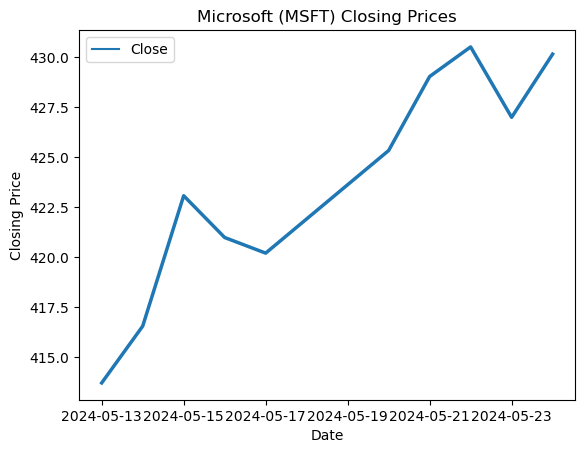

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary with the date and closing prices
data = {
    'Date': ['2024-05-13', '2024-05-14', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24'],
    'Close': [413.72, 416.56, 423.08, 420.99, 420.21, 425.34, 429.04, 430.52, 427.00, 430.16]
}

# Convert the dictionary into a DataFrame
df = pd.DataFrame(data)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Create a line plot of the closing prices
sns.lineplot(data=df, palette="tab10", linewidth=2.5)

# Set the title and labels
plt.title('Microsoft (MSFT) Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Display the plot
plt.show()